# Example: Current Oil Saturation and Residual State Maps Calculation
This notebook demonstrates the **initial implementation and workflow** (original methodology) for calculating **current oil saturation** (So_current) and related **reservoir state maps**. It represents the engineering prototype that later served as the prototype for a structured Python package.  

Use this notebook to understand the **evolution of the method and code**, explore the **underlying calculations** and see step-by-step computations before they were refactored into modular components.

### 🔢 Workflow Stages
1. Input Preparation
2. Saturation Calculation at Well Points (One-Phase Model)
3. Well Data Expansion to Trajectory Points
4. Influence Weights Calculation
5. Well Interference Calculation
6. Optimization and Interpolation: Material Balance Enforcement
7. Result Generation and Visualization

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import math
import json

In [2]:
# Folder with jupyter
current_folder_name = os.path.basename(os.getcwd())

## ⚙️ Step 1: Input Preparation  
---

* Import production/injection well data (coordinates, production/injection, operational status).
* Define reservoir and fluid properties and set calculation parameters.
* Load geological maps: porosity, net oil thickness (NNT), initial oil saturation.

In [3]:
# Load production/injection well data from pickle
with open(f"data_wells.pkl", 'rb') as f: 
    data_wells = pickle.load(f)

In [4]:
# Filtration
data_wells = data_wells[(data_wells['Qo_cumsum'] > 0) | (data_wells['Winj_cumsum'] > 0)].reset_index(drop=True)

In [5]:
# Required properties of reservoir and fluids and calculation parameters
# map_params
size_pixel = 50
switch_fracture = False

# reservoir_params
KIN = 0.336
azimuth_sigma_h_min = 45
# There are several options of calculating - using injection and length
l_half_fracture = 150

# fluid_params
pho_surf = 0.841
mu_o = 0.72
mu_w = 0.29
Bo = 1.241
Bw = 1.0

# relative_permeability_params 
Sor = 0.3
Swc = 0.2
Fw = 0.3
m1 = 1
Fo = 1.0
m2 = 1

# options
delta = 0.0001
betta = 1.5

In [6]:
# Generate dicts
map_params = {'size_pixel': size_pixel, 'switch_fracture': switch_fracture}
reservoir_params = {'KIN': KIN, 'azimuth_sigma_h_min': azimuth_sigma_h_min, 'l_half_fracture': l_half_fracture}
fluid_params = {'pho_surf': pho_surf, 'mu_o': mu_o, 'mu_w': mu_w, 'Bo': Bo, 'Bw': Bw}
relative_permeability_params = {'Sor': Sor, 'Swc': Swc, 'Fw': Fw, 'm1': m1, 'Fo': Fo, 'm2': m2}
options = {'delta': delta, 'betta': betta}

In [7]:
# Load geological maps metadata from JSON
with open(f"maps_metadata.json", "r", encoding="utf-8") as f:
    maps_metadata = json.load(f)

In [8]:
# Creating  dict with maps data
dict_maps = {}
for meta in maps_metadata:
    data = np.load(os.path.join(meta["data_file"]))
    type_map = meta["type_map"]
    dict_maps[meta["type_map"]] = data
    
# Initializing maps
map_initial_oil_saturation = dict_maps["initial_oil_saturation"]
map_initial_oil_saturation = np.where(map_initial_oil_saturation < Sor, 0, map_initial_oil_saturation)
map_NNT = dict_maps["NNT"]
map_porosity = dict_maps["porosity"]

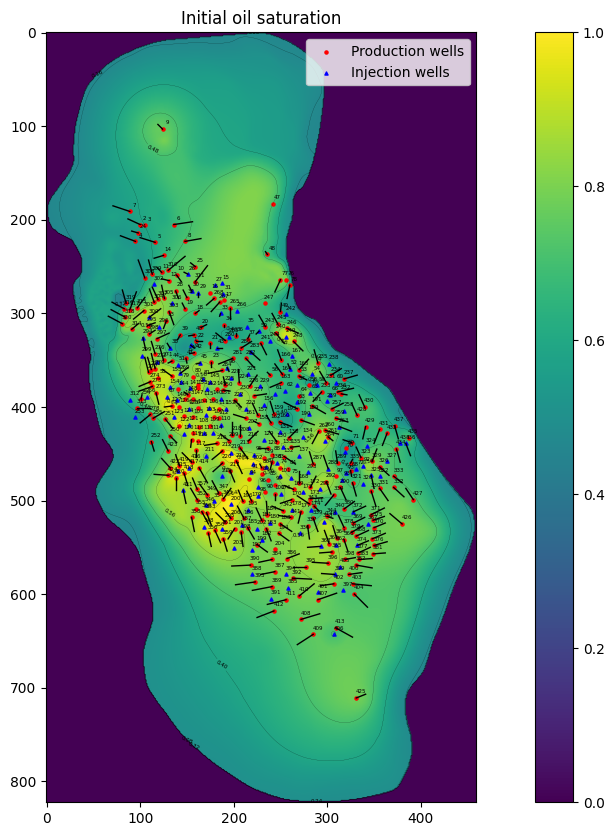

In [9]:
# Visualization of map_initial_oil_saturation
plt.figure(figsize=(15, 10))
plt.imshow(map_initial_oil_saturation, cmap="viridis", origin="upper")

# Plotting wells (T1 and T3)
for i, row in data_wells.iterrows():
    x_line = [row['T1_x_pix'], row['T3_x_pix']]
    y_line = [row['T1_y_pix'], row['T3_y_pix']]
    plt.plot(x_line, y_line, color="black", linewidth=1)

# Marking production wells
x_prod = data_wells[data_wells['work_marker'] == 'prod']['T1_x_pix']
y_prod = data_wells[data_wells['work_marker'] == 'prod']['T1_y_pix']
plt.scatter(x_prod, y_prod, c="red", marker="o", label="Production wells", s=5)

# Marking injection wells
x_inj = data_wells[data_wells['work_marker'] == 'inj']['T1_x_pix']
y_inj = data_wells[data_wells['work_marker'] == 'inj']['T1_y_pix']
plt.scatter(x_inj, y_inj, c="blue", marker="^", label="Injection wells", s=5)

# Well signatures
for i in range(len(data_wells)):
    plt.text(data_wells['T1_x_pix'][i] + 5, data_wells['T1_y_pix'][i] - 5,
             str(data_wells['well_number'][i]), fontsize=4, ha='center')

plt.colorbar()
plt.legend()
plt.title("Initial oil saturation")

# Adding isolines
levels = 10
contour = plt.contour(map_initial_oil_saturation, levels=levels, colors='black', linewidths=0.1)
plt.clabel(contour, inline=True, fontsize=4)

plt.show()

# 🛠️ Preparing data to determine current saturation
---
## 🧪 Step 2:  Saturation Calculation at Well Points (One-Phase Model)
---
* Generate **lists of grid coordinates** (points) belonging to wells.
* Account of auto-fracs at injection wells.
* Compute current oil saturation at well points using **water cut** and the **One-Phase Model** (*Buckley–Leverett*).
* Account for **displacement** and **fractional flow** using the **Buckley–Leverett** model.
* Extract initial oil saturation values from the map **initial_oil_saturation** at well points.
* Adjust the **endpoint water saturation (Swc)** based on the initial oil saturation map.

In [10]:
# To account for horizontal wells, we represent each well as a list of points on the grid.
# Add columns 'trajectory_x', 'trajectory_y' - lists of grid coordinates (points) belonging to wells.
from skimage.draw import line

def get_line_cells(x1, y1, x2, y2):
    """
    Generates discrete integer coordinates of a line on the grid between two points using Bresenham’s algorithm.
    """
    if x1 == x2 and y1 == y2:
        return [x1], [y1]
    rr, cc = line(int(y1), int(x1), int(y2), int(x2))  # skimage.draw.line return indices
    return cc.tolist(), rr.tolist()

data_wells['trajectory_x'], data_wells['trajectory_y'] = zip(*data_wells.apply(lambda row: get_line_cells(int(row['T1_x_pix']), int(row['T1_y_pix']), int(row['T3_x_pix']), int(row['T3_y_pix'])), axis=1))

In [11]:
# Account of auto-fracs at injection wells
def correction_injection_well_trajectory(coords_x, coords_y, sigma_h, l_half_fracture):
    """
    Reorients the injection well trajectory considering the direction of minimum horizontal stress.
    """
    # Determining  the coordinates of the frac center
    center_x, center_y = coords_x[len(coords_x)//2], coords_y[len(coords_y)//2]
    # Azimuth fracture
    azimuth_fracture = sigma_h + math.pi/2
    new_t1_x, new_t1_y = center_x + l_half_fracture * math.cos(azimuth_fracture), center_y + l_half_fracture * math.sin(azimuth_fracture)
    new_t3_x, new_t3_y = center_x - l_half_fracture * math.cos(azimuth_fracture), center_y - l_half_fracture * math.sin(azimuth_fracture)
    return get_line_cells(new_t1_x, new_t1_y, new_t3_x, new_t3_y)

In [12]:
def update_injection_trajectory(row):
    if row['work_marker'] == 'inj':
        new_x, new_y = correction_injection_well_trajectory(row['trajectory_x'], row['trajectory_y'],
                                                            sigma_h, l_half_fracture_pixel)
        row['trajectory_x'] = new_x
        row['trajectory_y'] = new_y
    return row

if map_params['switch_fracture']:
    # Getting params for accounting auto-fracs at injection wells
    sigma_h = math.radians(reservoir_params['azimuth_sigma_h_min'])
    l_half_fracture_pixel = reservoir_params['l_half_fracture'] / map_params['size_pixel']
    data_wells = data_wells.apply(update_injection_trajectory, axis=1)

In [13]:
def get_saturation_points(row, map_initial_oil_saturation, fluid_params, relative_permeability_params):
    """
    Calculates initial and current oil saturation at each point of the well trajectory.
    """
    traj_x = row['trajectory_x']
    traj_y = row['trajectory_y']
    So_current_wells = []
    So_init_wells = []

    for x, y in zip(traj_x, traj_y):
        # Get init oil saturation from map
        So_init_point = map_initial_oil_saturation[y, x]

        row_copy = row.copy()
        row_copy['So_init'] = So_init_point

        # Calculating current oil saturation for point of grid
        So_current_point = get_current_So(row_copy, fluid_params, relative_permeability_params)

        So_current_wells.append(So_current_point)
        So_init_wells.append(So_init_point)

    return pd.Series([So_init_wells, So_current_wells])

In [14]:
def get_current_So(row, fluid_params, relative_permeability_params):
    """
    Calculates current oil saturation at wells
    """
    # Extracting params of relative phase permeability
    Swc, Sor, Fw, m1, Fo, m2 = (relative_permeability_params['Swc'], 
                                relative_permeability_params['Sor'], 
                                relative_permeability_params['Fw'],
                                relative_permeability_params['m1'], 
                                relative_permeability_params['Fo'], 
                                relative_permeability_params['m2'])
    # Extracting params of fluids
    mu_w, mu_o, Bw, Bo = fluid_params['mu_w'], fluid_params['mu_o'], fluid_params['Bw'], fluid_params['Bo']
    # Endpoint water saturation Swc (minimum) in accordance with map_initial_oil_saturation
    Swc = 1 - row['So_init']
    f_w = row['water_cut']
    # Production well
    if row.work_marker == "prod":
        # Current water saturation
        Sw = get_sw(mu_w, mu_o, Bo, Bw, f_w, Fw, m1, Fo, m2, Swc, Sor)
        return 1 - Sw  # Current oil saturation
    # Injection well
    else:
        return Sor

### Description the One-Phase Model (Buckley–Leverett)

In [15]:
# Description the One-Phase Model (Buckley–Leverett) for accounting for displacement and fractional flow.
from scipy.optimize import bisect
def get_sw(mu_w, mu_o, Bo, Bw, f_w, Fw, m1, Fo, m2, Swc, Sor):
    """
    Computes water saturation (Sw) based on water cut (fw) by solving the inverse problem using the bisection method.
    """
    Sw_min = Swc  # нижняя граница интервала поиска решения
    Sw_max = 1 - Sor  # верхняя граница интервала поиска решения
    # проверка краевых значений
    if f_w <= get_f_w(mu_w, mu_o, Bo, Bw, Sw_min, Fw, m1, Fo, m2, Swc, Sor):
        Sw = Sw_min
    elif f_w >= get_f_w(mu_w, mu_o, Bo, Bw, Sw_max, Fw, m1, Fo, m2, Swc, Sor):
        Sw = Sw_max
    else:
        Sw = bisect(lambda Sw: f_w - get_f_w(mu_w, mu_o, Bo, Bw, Sw, Fw, m1, Fo, m2, Swc, Sor), Sw_min, Sw_max)
        # доп параметры: xtol=0.0001 необходимая точность решения, maxiter=1000 максимальное число итераций
    return Sw


def get_f_w(mu_w, mu_o, Bo, Bw, Sw, Fw, m1, Fo, m2, Swc, Sor):
    """
    Computes fractional flow of water (fw) as a function of water saturation (Sw) using the Buckley–Leverett.
    """
    k_rw = get_k_corey(Fw, m1, Swc, Sor, Sw, type="water")  # ОФП по воде
    k_ro = get_k_corey(Fo, m2, Swc, Sor, Sw, type="oil")  # ОФП по нефти
    try:
        f_w = 100 / (1 + (k_ro * mu_w * Bw) / (k_rw * mu_o * Bo))
    except ZeroDivisionError:
        f_w = 0
    return f_w


def get_k_corey(F, m, Swc, Sor, Sw, type):
    """
    Computes relative phase permeability for oil/water as functions of water saturation (Sw) based on the Corey model.
    """
    if Sw == 1 and type == "water":
        return 1
    elif Sw == 1 and type == "oil":
        return 0
    else:
        try:
            Sd = (Sw - Swc) / (1 - Sor - Swc)  # Приведенная водонасыщенность пласта
        except ZeroDivisionError:
            Sd = 1
        if type == "water":
            return F * (Sd ** m)
        elif type == 'oil':
            return F * ((1 - Sd) ** m)

In [16]:
# Compute current oil saturation and get init oil saturation from map at well points of trajectory.
data_wells[['So_init', 'So_current']] = data_wells.apply(get_saturation_points, 
                                                         args=(map_initial_oil_saturation, 
                                                               fluid_params, 
                                                               relative_permeability_params), axis=1)

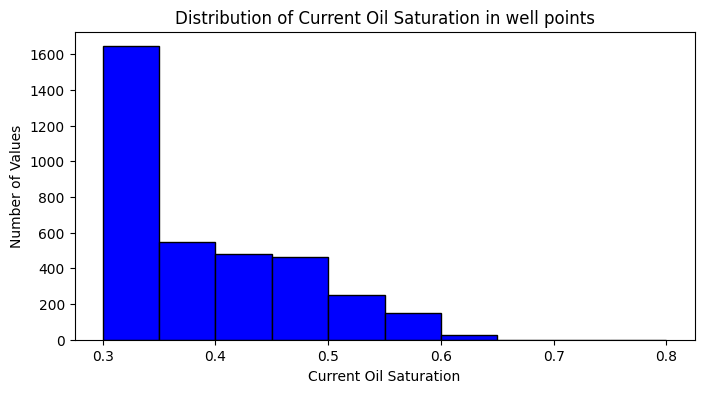

In [17]:
# Distribution of current oil saturation in well points
So_current_values = np.concatenate(data_wells["So_current"].values)

plt.figure(figsize=(8, 4))
plt.hist(So_current_values, bins=10, color='blue', edgecolor='black', range=(Sor, 1 - Swc))
plt.xlabel("Current Oil Saturation")
plt.ylabel("Number of Values")
plt.title("Distribution of Current Oil Saturation in well points")
plt.show()

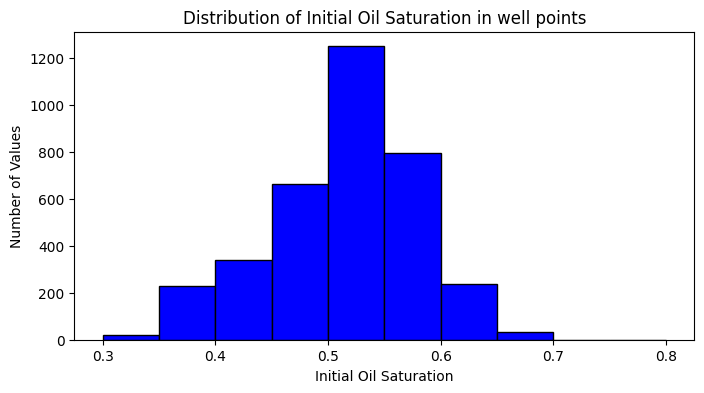

In [18]:
# Distribution of current oil saturation in well points
So_init_values = np.concatenate(data_wells["So_init"].values)

plt.figure(figsize=(8, 4))
plt.hist(So_init_values, bins=10, color='blue', edgecolor='black',  range=(Sor, 1 - Swc))
plt.xlabel("Initial Oil Saturation")
plt.ylabel("Number of Values")
plt.title("Distribution of Initial Oil Saturation in well points")
plt.show()

## 📍 Step 3: Well Data Expansion to Trajectory Points
---
* Expands well data to trajectory points.

In [19]:
# Lists of required parameters
(x, y, r_eff, time_off, work_markers, k, h, Qo_cumsum, Winj_cumsum, So_current_wells, So_init_wells) = (
    [], [], [], [], [], [], [], [], [], [], [])
for _, row in data_wells.iterrows():
    x.extend(row['trajectory_x'])
    y.extend(row['trajectory_y'])
    len_trajectory = len(row['trajectory_x'])
    r_eff.extend([row["r_eff"] / map_params['size_pixel']] * len_trajectory)
    time_off.extend([row["no_work_time"]] * len_trajectory)
    work_markers.extend([row['work_marker']] * len_trajectory)
    k.extend([row["permeability"]] * len_trajectory)
    h.extend([row['NNT']] * len_trajectory)
    Qo_point = row['Qo_cumsum'] / len_trajectory
    Qo_cumsum.extend([Qo_point] * len_trajectory)
    Winj_point = row['Winj_cumsum'] / len_trajectory
    Winj_cumsum.extend([Winj_point] * len_trajectory)
    So_current_wells.extend(row["So_current"])
    So_init_wells.extend(row["So_init"])

x, y = np.array(x), np.array(y)
well_coord = np.column_stack((x, y))
So_current_wells, So_init_wells = np.array(So_current_wells).astype('float32'), np.array(So_init_wells).astype('float32')
r_eff, time_off, work_markers  = np.array(r_eff).astype('float32'), np.array(time_off), np.array(work_markers)
k, Qo_cumsum, Winj_cumsum, h = np.array(k), np.array(Qo_cumsum), np.array(Winj_cumsum), np.array(h)

In [20]:
Qo_sum = sum(Qo_cumsum)
print(f"Qo_sum: {Qo_sum:.0f} ton")
Qo_sum_V = Qo_sum / pho_surf * Bo
print(f"Qo_sum_V: {Qo_sum_V:.0f} m3")

Qo_sum: 8752395 ton
Qo_sum_V: 12915247 m3


## 📊 Step 4: Influence Weights Calculation
---
**Influence weight calculation** of each well point on each cell — used to distribute oil saturation across the grid.
* Calculate pore volume.
* Create grid.
* Compute distance from each grid cell to each well point.
* Calculate influence weights: accounting downtime (time_off), permeability (k), distances, r_eff

In [21]:
# Calculating reservoir pore volume <data_volumes>
cell_area = size_pixel ** 2
data_volumes = cell_area * map_NNT * map_porosity

# Creating grid 
x_coords = np.arange(0, data_volumes.shape[1], 1)
y_coords = np.arange(0, data_volumes.shape[0], 1)
x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)
cells = pd.DataFrame({'x': x_mesh.ravel(), 'y': y_mesh.ravel()})

grid_points = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))

In [22]:
# Calculating influence weights for each well
from scipy.spatial.distance import cdist

# Flattened initial oil saturation array
flat_So_init = map_initial_oil_saturation.ravel()    

# Boolean mask array indicating valid cells with oil.
mask = flat_So_init > 0
valid_points = grid_points[mask]

# Calculating of distances from each cell to each well
distances = cdist(valid_points, well_coord).astype('float32')

# Influence weights
# Accounting for downtime and permeability
psi = np.exp(-delta * k * time_off)
weights = r_eff * psi / (distances**2 + 1e-12)
weights /= (np.sum(weights, axis=1, keepdims=True) + 1e-12)  # weight normalization
weights = weights.astype('float32')

## 🕸️ Step 5: Well Interference Calculation
---
### Accounting for Influence Radii in Oil Saturation
It's necessary to get an array of values **r_jl** for each well points, 
which depend on the **directions of alpha_ij vectors** from each well point to each cell of grid.

**Algorithm:**
1. Calculate direction matrix **alpha_ij** for each cell of grid.
2. Compute correlation table **r_jl**(alpha_ij) using **calculate_r_jl_values** for each point.
3. Let pass matrix alpha_ij through get_r_jl to get **radius matrix**.
4. Add the resulting array to the general matrix, use for oil saturation calculations and updating effective radius of wells.
5. !NB For injectors points, use a base r_jl matrix from effective radii of point (or 1?)

In [23]:
# 1. Calculating the matrix of the injection direction angles for each point of the production well
def calculate_alpha(point_center, point_cell):
    """
    Vectorized angle calculation (radians) from 'point_center' to 'point_cell'.
    """
    x1, y1 = point_center
    x2, y2 = point_cell

    dx = x2 - x1
    dy = y2 - y1
    angle = np.arctan2(dy, dx)
    return np.where(angle < 0, angle + 2 * np.pi, angle)

In [24]:
def calculate_S_polygon(lambdas, delta_theta):
    # Create pairs of nearby elements: (λ₁, λ₂), (λ₂, λ₃), ..., (λ_M, λ_{M+1})
    pairs = zip(lambdas[:-1], lambdas[1:])
    
    # Calculating the sum of products of pairs
    total_sum = sum(a * b for a, b in pairs)
    
    S = (math.sin(delta_theta) / 2) * total_sum
    return S

In [25]:
def calculate_eta(R_x, lambdas, delta_theta):
    """
    Compute η = Rₓ * √(2π / (sin(Δθ) * Σ(λₖ * λₖ₊₁))).
    """
    S = calculate_S_polygon(lambdas, delta_theta)
    eta = R_x * math.sqrt( math.pi / (S + 1e-12))
    return eta

In [26]:
def calculate_r_jl(L_k_list, delta_theta, alpha):
    """
    Compute r_jl(alpha) with account of the circular structure of rays (0..2π).
    Vectorized version.
    """
    # Преобразуем вход в numpy array, если это скаляр
    alpha = np.asarray(alpha)
    scalar_input = False
    if alpha.ndim == 0:
        alpha = alpha[None]  # Делаем 1D массив
        scalar_input = True
        
    num_rays = len(L_k_list)
    alpha_norm = alpha % (2 * np.pi)  # Нормализация угла к [0, 2π)
    # Вычисляем индексы k для каждого угла
    k = (alpha_norm // delta_theta).astype(int) % num_rays
    
    # Получаем соответствующие L_k и L_k+1
    L_k = L_k_list[k]
    L_k_plus_1 = L_k_list[(k + 1) % num_rays]
    
    # Вычисляем числитель и знаменатель
    numerator = L_k * L_k_plus_1 * np.sin(delta_theta)
    term1 = L_k_plus_1 * np.sin((k + 1) * delta_theta - alpha_norm)
    term2 = L_k * np.sin(alpha_norm - k * delta_theta)
    denominator = term1 + term2
    
    # Избегаем деления на ноль (можно добавить малую константу)
    epsilon = 1e-10
    denominator = np.where(np.abs(denominator) < epsilon, epsilon, denominator)
    
    r_jl = numerator / denominator
    
    # Возвращаем скаляр, если на входе был скаляр
    return r_jl[0] if scalar_input else r_jl

In [27]:
# 2. Calculating correlation table r_jl(alpha_ij) for each point.
def calculate_r_jl_values(point_well, r_eff, interferense_values, centers_x, centers_y,
                          delta_theta=np.pi/10, num_points=365):
    """
    Compute r_jl(alpha) table — influence radii depending on angle.
    """
    # 1. Calculating array_alpha -  the matrix of the injection direction angles 
    array_alpha = calculate_alpha(point_well, (centers_x,centers_y))

    # 2. Calculating array_lambda_k - projections of injector influence fractions onto rays with constant delta-theta
    list_angles = np.arange(0, 2*np.pi + delta_theta, delta_theta)
    alpha_array = np.array(array_alpha)

    # Angle conditions and correction
    mask1 = (list_angles[:, None] >= 3/2 * np.pi) & ((alpha_array >= 0) & (alpha_array <= np.pi/2))
    alpha_corrected = np.where(mask1, alpha_array + 2 * np.pi, alpha_array)

    # Projections 
    mask2 = np.abs(alpha_corrected - list_angles[:, None]) <= np.pi/2
    cos_diff = np.cos(alpha_corrected - list_angles[:, None])
    lambda_k = np.sum(interferense_values * cos_diff * mask2, axis=1)

    # 3. Ray scaling
    eta = calculate_eta(r_eff, lambda_k, delta_theta)  
    L_k_list = lambda_k * eta

    # 4. Calculating r_jl_values - a table of interaction radii as a function of angle
    alpha_angles = np.linspace(0, 2 * np.pi, num_points, endpoint=True)
    r_jl_values = calculate_r_jl(L_k_list, delta_theta, alpha_angles)

    return alpha_angles, r_jl_values

In [28]:
def get_r_jl(target_angles, angles, r_jl_values):
    """
    Get matrix of r_jl for one point.
    """
    # Finding nearest angle indices (binary search)
    idx = np.searchsorted(angles, target_angles, side="left")
    
    # Handling  boundary cases (when target_angle falls outside angles)
    idx = np.clip(idx, 1, len(angles) - 1)
    
    # Getting nearby angles and the r_jl values
    alpha_prev = angles[idx - 1]
    alpha_next = angles[idx]
    r_prev = r_jl_values[idx - 1]
    r_next = r_jl_values[idx]
    
    # Computing interpolation weights
    # If alpha_next == alpha_prev, interpolation is not possible, so we take r_prev
    mask = (alpha_next != alpha_prev)
    weights = np.zeros_like(target_angles)
    weights[mask] = (target_angles[mask] - alpha_prev[mask]) / (alpha_next[mask] - alpha_prev[mask])
    
    # Linear interpolation
    r_interpolated = r_prev + (r_next - r_prev) * weights
    
    return r_interpolated

In [29]:
def calc_interferense_matrix(point_coord, work_marker_point, grid_point_wells, array_h, array_Winj, array_Qo, array_work_marker, max_distance=1000):
    """
    Compute interference coefficients between wells (participation and influence coefficients).
    """
    array_distance = np.linalg.norm(grid_point_wells - point_coord, axis=1)
    mask_nearest_points = (array_distance <= max_distance) & (array_distance > 0)
    mask_marker = array_work_marker != work_marker_point
    mask_general = mask_nearest_points & mask_marker
    if work_marker_point == 'prod':
        # Calculating influence coefficients for production wells
        lambda_ij = array_h[mask_general] * array_Winj[mask_general] / array_distance[mask_general]  
        lambda_ij = lambda_ij / lambda_ij.sum()
    else:
        # Calculating participation coefficients for injection wells
        lambda_ij = array_h[mask_general] * array_Qo[mask_general] / array_distance[mask_general]  
        lambda_ij = 1 - lambda_ij / lambda_ij.sum()
    return lambda_ij, mask_general

In [30]:
# Calculate local influence radius matrix r_ij for each point.
matrix_r_ij = np.empty((valid_points[:, 1].shape[0],len(x)), dtype=np.float32)
index = 0
for index_point in range(len(x)):
    x_point, y_point, work_marker_point, R_n = x[index_point], y[index_point], work_markers[index_point], r_eff[index_point]
    if work_marker_point == 'prod' or work_marker_point == 'inj':
        # Getting interference coefficients from matrix for codependent injectors
        interferense_array, mask_general = calc_interferense_matrix(np.array([x_point, y_point]), work_marker_point, 
                                                                           well_coord, h, Winj_cumsum, Qo_cumsum, work_markers)
        # Getting injector centers
        centers_x, centers_y = x[mask_general], y[mask_general]
        # Computing array of direction angles alpha_ij
        array_alpha_ij = calculate_alpha((x_point, y_point), (valid_points[:, 0], valid_points[:, 1]))
        # Calculating the correlation table r_jl(alpha_ij) using calculate_r_jl_values
        angles, r_jl_values_prod_well = calculate_r_jl_values((x_point, y_point), R_n, interferense_array,
                                                              centers_x, centers_y)
        # Running array_alpha_ij through get_r_jlto obtain a matrix of interaction radii for one point
        array_r_jl = get_r_jl(array_alpha_ij, angles, r_jl_values_prod_well)
        matrix_r_ij[:, index] = array_r_jl.ravel()
        index+=1
    else:
        print(0)
        matrix_r_ij[:, index] = np.full(valid_points[:, 1].shape[0], R_n/default_size_pixel)
        index+=1
matrix_r_ij.shape

(227612, 3565)

## 💧 Step 6: Optimization and Interpolation: Material Balance Enforcement
---
* Apply **exponential decay** weighting functions.
* **Interpolate current oil saturation** of point values over the entire grid based on weighted well interference.
* Adjust saturation using **optimization** techniques **minimize_scalar** to match historical cumulative production.
* Enforce **material balance**:  
**V<sub>current</sub> = V<sub>OIIP</sub> − V<sub>prod</sub>**

In [31]:
# Calculation of coefficients for accounting in exponential decay
weights_diff_saturation = weights * (So_init_wells - So_current_wells) 
influence_matrix = ((distances + matrix_r_ij) / r_eff) ** betta

In [32]:
# Minimum allowable saturation map accounting for recovery factor.
So_min = map_initial_oil_saturation * (1 - reservoir_params['KIN'])

In [33]:
def interpolate_current_saturation(gamma, flat_So_init, mask, weights_diff_saturation, influence_matrix, relative_permeability_params):
    """
    Interpolation of the current oil saturation based on influence weights and wells interaction.
    """
    data_So_current = np.copy(flat_So_init)
    data_So_current[mask] -= np.sum(weights_diff_saturation * np.exp(-gamma * influence_matrix), axis=1)
    data_So_current[mask] = np.maximum(data_So_current[mask], relative_permeability_params['Sor'])
    return data_So_current

In [34]:
def oil_production_loss(gamma):
    """
    Calculates the squared error loss between estimated oil production volume and actual oil production volume.
    """
    data_So_current = (interpolate_current_saturation(gamma, flat_So_init, mask, weights_diff_saturation,
                                                      influence_matrix, relative_permeability_params)
                       .reshape(map_initial_oil_saturation.shape))
    # Historical cumulative production in cells = (map_initial_oil_saturation - data_So_current) in pore volume
    oil_extracted = (map_initial_oil_saturation - data_So_current) * data_volumes
    # Boolean mask indicating constraint violations
    mask_limit = (data_So_current < So_min)
    # In cells, where the limit is violated, we consider it as if we produce only up to SHein
    oil_extracted[mask_limit] = (map_initial_oil_saturation[mask_limit] - So_min[mask_limit]) * data_volumes[mask_limit]
    print(gamma)
    return (np.sum(oil_extracted) - Qo_sum_V) ** 2

In [35]:
def intermediate_loss(gamma):
    """
    Wrapper for oil production loss that logs intermediate optimization results.
    """
    loss = oil_production_loss(gamma)
    print(f"gamma={gamma:.5f}, loss={loss:.0f}")
    return loss

In [36]:
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import time

start_time = time.time()
# Optimizes the gamma parameter to minimize the oil production loss function.
res = minimize_scalar(intermediate_loss, bounds=(0, 1), method='bounded')
optimal_gamma = res.x
print("Optimal value of gamma: ", optimal_gamma)
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ', elapsed_time)

0.3819660112501051
gamma=0.38197, loss=102070421239253
0.6180339887498948
gamma=0.61803, loss=119426556979255
0.2360679774997897
gamma=0.23607, loss=83106911243752
0.14589803375031546
gamma=0.14590, loss=63798925504703
0.09016994374947425
gamma=0.09017, loss=45066825423142
0.055728090000841224
gamma=0.05573, loss=27603396464541
0.03444185374863304
gamma=0.03444, loss=12422734369703
0.0212862362522082
gamma=0.02129, loss=1998601291274
0.013155617496424847
gamma=0.01316, loss=1263573926911
0.015850263066096555
gamma=0.01585, loss=8801449799
0.016779042760967217
gamma=0.01678, loss=43962749178
0.01617843566454237
gamma=0.01618, loss=257922240
0.016136713619636138
gamma=0.01614, loss=5084834
0.016130530336537007
gamma=0.01613, loss=42831
0.016127196763949244
gamma=0.01613, loss=810076
Optimal value of gamma:  0.016130530336537007
Elapsed time:  171.684716463089


## ✅ Step 7: Result Generation and Visualization
---
* Generate result maps (2D-arrays) and visualize them., such as:  
  
    -  Current oil saturation (`data_So_current`)
    -  Water Cut (`data_water_cut`)
    -  Oil initially in place (`data_OIIP`)
    -  Initial recoverable oil reserves (`data_IRR`)
    -  Residual recoverable oil reserves (`data_RRR`)

### Current Oil Saturation Map

In [37]:
# 2D array of the current oil saturation distributed across the grid
map_current_oil_saturation = interpolate_current_saturation(optimal_gamma, flat_So_init, mask, weights_diff_saturation, influence_matrix, relative_permeability_params).reshape(map_initial_oil_saturation.shape)

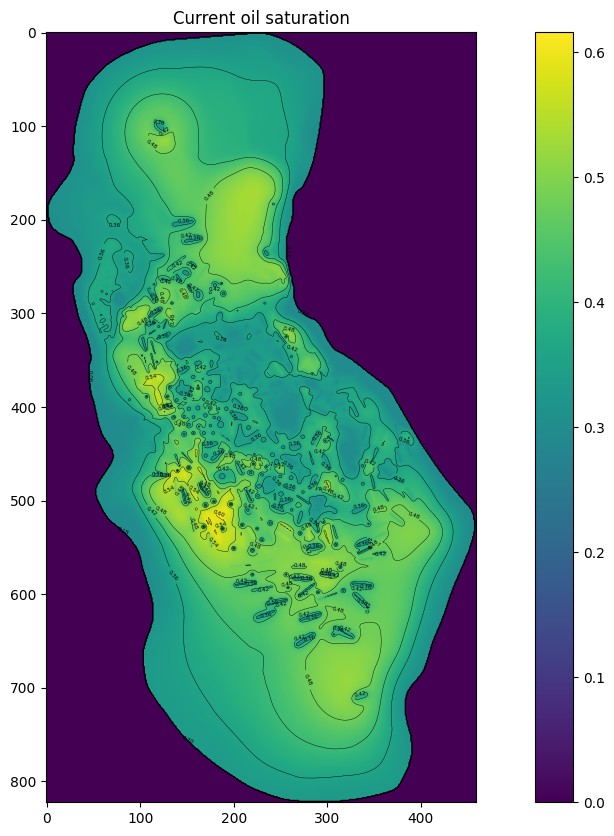

In [38]:
# Visualization of the map_current_oil_saturation
plt.figure(figsize=(15, 10))
plt.imshow(map_current_oil_saturation, cmap="viridis", origin="upper")
plt.title("Current oil saturation")
plt.colorbar()
# Adding isolines
levels = 10
contour = plt.contour(map_current_oil_saturation, levels=levels, colors='black', linewidths=0.3)
plt.clabel(contour, inline=True, fontsize=4)

plt.show()

### Water cut map

In [39]:
# Current water saturation
array_Sw = 1.0 - map_current_oil_saturation 
# Adjust the endpoint water saturation (Swc) based on map_initial_oil_saturation
array_Swc = 1.0 - map_initial_oil_saturation

In [40]:
# Using one-phase-model to get water cut (get_f_w)
vectorized_get_f_w = np.vectorize(get_f_w)
f_w_array = vectorized_get_f_w(mu_w, mu_o, Bo, Bw, array_Sw, Fw, m1, Fo, m2, array_Swc, Sor)

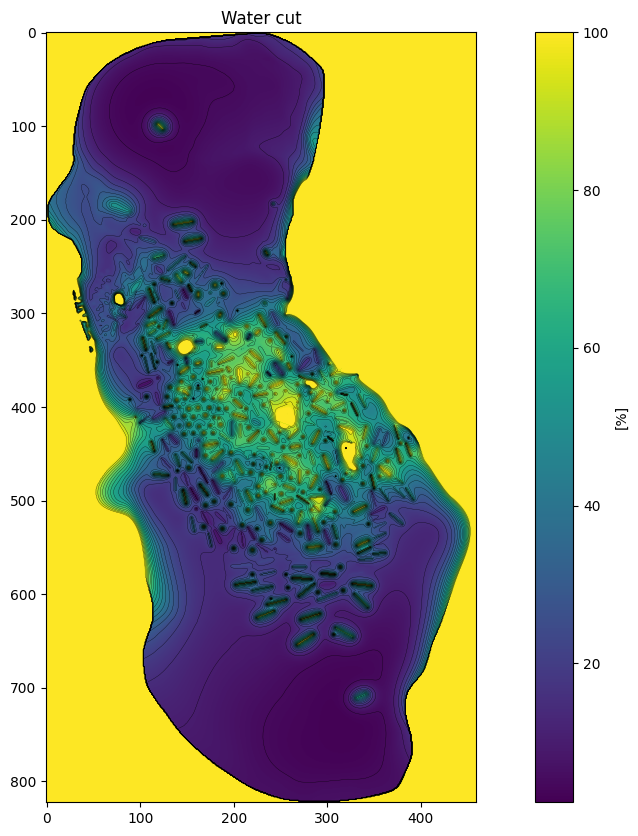

In [52]:
# Creating coord grid for f_w_array
x = np.arange(f_w_array.shape[1])
y = np.arange(f_w_array.shape[0])
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(15, 10))
img = plt.imshow(f_w_array, origin="upper") 
levels = np.arange(0, 101, 5)
plt.contour(X, Y, f_w_array, levels=levels, colors='black',  linewidths=0.2)
     
plt.colorbar(img, label='[%]') 
plt.title("Water cut")
plt.show()

### Oil Initially In Place (OIIP) Map

In [42]:
# 2D array of the oil initially in place (OIIP)
# Multiplication by 10000 is required to convert reserve density units from tons per square meter (tons/m²) to tons per hectare (tons/ha)
map_OIIP  = map_NNT * map_initial_oil_saturation * map_porosity * pho_surf * 10000  / Bo  # [tons/ha]
OIIP = np.sum(map_OIIP * size_pixel ** 2 / 10000)  # [tons]
print(f"Calculated oil initially in place (OIIP): {OIIP / 1000:.1f} thousand tons")

Calculated oil initially in place (OIIP): 84834.1 thousand tons


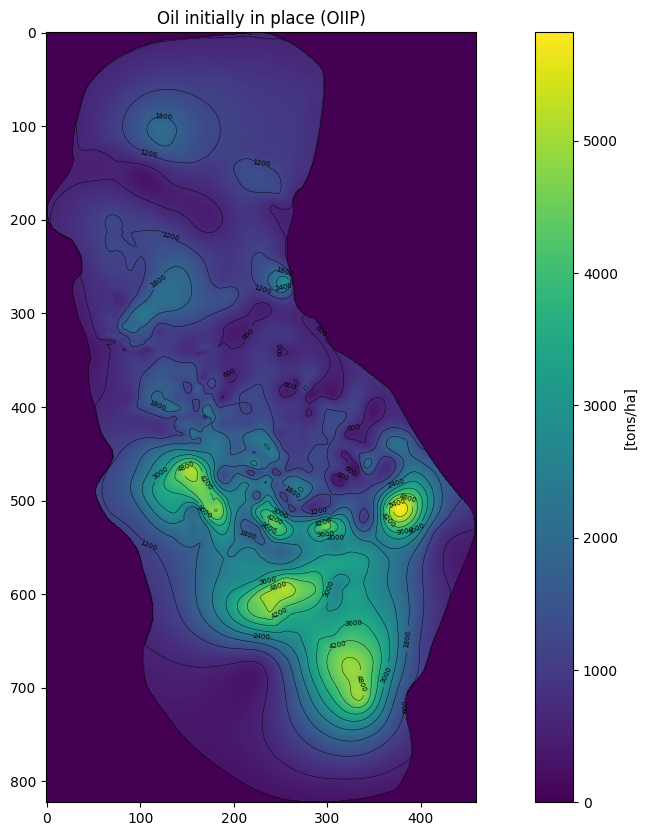

In [43]:
# Visualization of the map_OIIP
plt.figure(figsize=(15, 10))
plt.imshow(map_OIIP, origin="upper")   
plt.title("Oil initially in place (OIIP)")
plt.colorbar(label='[tons/ha]')
# Adding isolines
levels = 10
contour = plt.contour(map_OIIP, levels=levels, colors='black', linewidths=0.3)
plt.clabel(contour, inline=True, fontsize=5)

plt.show()

### Initial Recoverable Oil Reserves (IRR) map

In [44]:
# 2D array of the initial recoverable oil reserves (IRR)
map_IRR = map_OIIP * KIN
IRR = OIIP * KIN
print(f'Calculated initial recoverable oil reserves (IRR): {IRR  / 1000:.1f} thousand tons')

Calculated initial recoverable oil reserves (IRR): 28504.3 thousand tons


### Remaining Oil In Place (ROIP) map

In [45]:
# 2D array of the remaining oil in place (ROIP)
# Multiplication by 10000 is required to convert reserve density units from tons per square meter (tons/m²) to tons per hectare (tons/ha)
map_ROIP = map_NNT * map_current_oil_saturation * map_porosity * pho_surf * 10000  / Bo
ROIP = np.sum(map_ROIP * size_pixel ** 2 / 10000)
print(f'Calculated remaining oil in place (ROIP): {ROIP / 1000:.1f} thousand tons')

Calculated remaining oil in place (ROIP): 75991.2 thousand tons


### Residual Recoverable Oil Reserves (RRR) map

In [46]:
# 2D array of the residual recoverable oil reserves (RRR)
map_RRR = map_ROIP - map_OIIP * (1 - KIN)
map_RRR[map_RRR < 0] = 0
RRR = np.sum(map_RRR * size_pixel ** 2 / 10000)
print(f'Calculated remaining oil in place (RRR): {RRR / 1000} thousand tons')

Calculated remaining oil in place (RRR): 19752.012 thousand tons


In [47]:
print(f'Oil production difference: {(((IRR - RRR) - Qo_sum) / Qo_sum * 100):.3f} %')

Oil production difference: -0.002 %


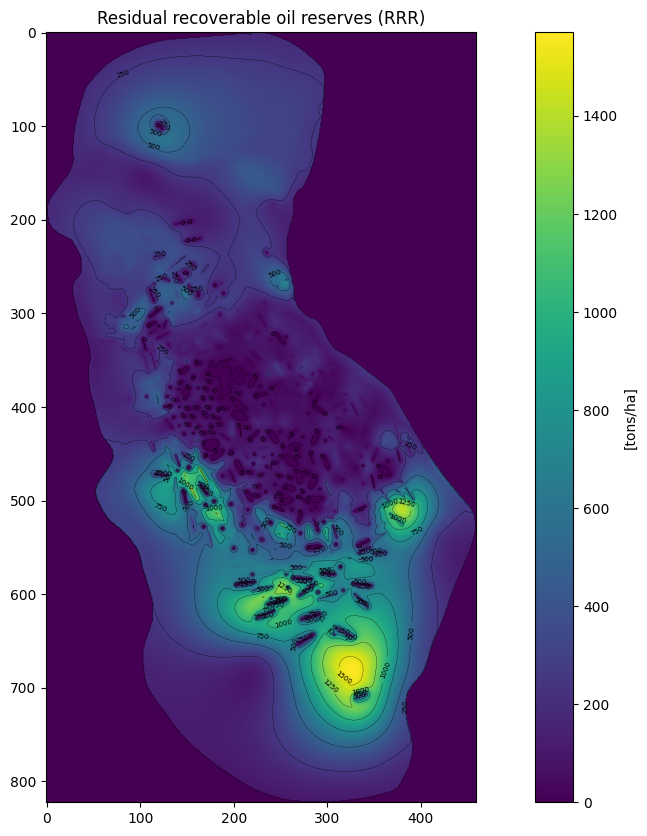

In [48]:
# Visualization of the map_RRR
plt.figure(figsize=(15, 10))
plt.imshow(map_RRR, origin="upper")   
plt.title("Residual recoverable oil reserves (RRR)")
plt.colorbar(label='[tons/ha]')
# Adding isolines
levels = 6
contour = plt.contour(map_RRR, levels=levels, colors='black', linewidths=0.2)
plt.clabel(contour, inline=True, fontsize=5)

plt.show()